In [30]:
import numpy as np
import pandas as pd
import yfinance as yf
import concurrent.futures
import matplotlib.pyplot as plt
import logging

class OptionsTrader:
    def __init__(self, initial_cash=100000, desired_position_size=1, profit_target=0.2, stop_loss=0.1):
        self.initial_cash = initial_cash
        self.desired_position_size = desired_position_size
        self.profit_target = profit_target
        self.stop_loss = stop_loss

        self.portfolio = {'cash': initial_cash, 'positions': []}
        self.logger = logging.getLogger(__name__)
        self.asset_values = []
        self.cash_balances = []
        self.total_values = []
        self.selected_strategies = {}
        self.dates = []
        self.transactions = pd.DataFrame(columns=['date', 'type', 'price', 'strategy', 'num_shares', 'ticker'])
        
    def collect_information(self):
        return {
            'portfolio': self.portfolio,
            'asset_values': self.asset_values,
            'cash_balances': self.cash_balances,
            'total_values': self.total_values,
            'transactions': self.transactions,
            'dates': self.dates,
        }

    def fetch_options_data(self, ticker):
        options_data = {}
        exp_dates = yf.Ticker(ticker).options
        with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
            future_to_exp_date = {executor.submit(self.fetch_single_option_chain, ticker, exp_date): exp_date for exp_date in exp_dates}
            for future in concurrent.futures.as_completed(future_to_exp_date):
                exp_date = future_to_exp_date[future]
                try:
                    exp_date, data = future.result()
                    if data is not None:
                        options_data[exp_date] = data
                except Exception as e:
                    self.logger.error(f"Error fetching options data for {ticker} on {exp_date}: {e}")
        return options_data

    def fetch_single_option_chain(self, ticker, exp_date):
        try:
            options_chain = yf.Ticker(ticker).option_chain(exp_date)
            calls = options_chain.calls[['strike', 'lastPrice']].rename(columns={'lastPrice': 'call_premium'})
            puts = options_chain.puts[['strike', 'lastPrice']].rename(columns={'lastPrice': 'put_premium'})
            merged = calls.set_index('strike').join(puts.set_index('strike'))
            return exp_date, merged
        except Exception as e:
            self.logger.error(f"Error fetching options data for {ticker} on {exp_date}: {e}")
            return exp_date, None

    def run_trader(self, ticker1, ticker2, start_date, end_date):
        self.ticker1 = ticker1
        self.ticker2 = ticker2
        self.start_date = start_date
        self.end_date = end_date

        try:
            historical_data1 = yf.download(ticker1, start=start_date, end=end_date)
            historical_data2 = yf.download(ticker2, start=start_date, end=end_date)
            if historical_data1.empty or historical_data2.empty:
                self.logger.error(f"No historical data found for {ticker1} or {ticker2}")
                return
        except Exception as e:
            self.logger.error(f"Error fetching historical data for {ticker1} or {ticker2}: {e}")
            return

        historical_close1 = historical_data1['Close']
        historical_close2 = historical_data2['Close']
        sigma1 = self.calculate_real_sigma(historical_close1)
        sigma2 = self.calculate_real_sigma(historical_close2)

        # NOTE: these options are present, all expiries in the future
        options_data1 = self.fetch_options_data(ticker1)
        options_data2 = self.fetch_options_data(ticker2)
        # print("options data")
        # display(options_data1)

        volatility_factor = self.calculate_volatility_factor(historical_close1, historical_close2)

        for current_date in pd.date_range(start=start_date, end=end_date, freq='B'):
            current_date_str = current_date.strftime('%Y-%m-%d')
            if current_date_str in historical_data1.index and current_date_str in historical_data2.index:
                current_price1 = historical_data1.loc[current_date_str, 'Close']
                current_price2 = historical_data2.loc[current_date_str, 'Close']
                
                # BUG: Does this not assume that all options from today can be exercised at any point in the past
                for exp_date, data in options_data1.items():
                    try:
                        if data is None:
                            continue

                        T = (pd.to_datetime(exp_date) - pd.to_datetime(current_date)).days / 365
                        self.evaluate_and_store_best_strategy(data, ticker1, current_price1, T, sigma1, volatility_factor)

                    except Exception as e:
                        self.logger.error(f"Error evaluating strategies for {ticker1} on {exp_date}: {e}")
                        continue

                for exp_date, data in options_data2.items():
                    try:
                        if data is None:
                            continue

                        T = (pd.to_datetime(exp_date) - pd.to_datetime(current_date)).days / 365
                        self.evaluate_and_store_best_strategy(data, ticker2, current_price2, T, sigma2, volatility_factor)

                    except Exception as e:
                        self.logger.error(f"Error evaluating strategies for {ticker2} on {exp_date}: {e}")
                        continue

                self.allocate_capital(current_date_str, current_price1, ticker1)
                self.allocate_capital(current_date_str, current_price2, ticker2)

                self.check_sell_conditions(ticker1, current_price1, current_date_str)
                self.check_sell_conditions(ticker2, current_price2, current_date_str)

                self.update_portfolio_value(ticker1, current_price1, current_date_str)
                self.update_portfolio_value(ticker2, current_price2, current_date_str)

            # break

        self.flatten_positions(ticker1, current_price1, current_date_str)
        self.flatten_positions(ticker2, current_price2, current_date_str)
        self.update_portfolio_value(ticker1, current_price1, current_date_str)
        self.update_portfolio_value(ticker2, current_price2, current_date_str)

    def calculate_real_sigma(self, historical_prices):
        log_returns = np.log(historical_prices / historical_prices.shift(1)).dropna()
        sigma = np.std(log_returns) * np.sqrt(252)  # Annualize the volatility
        return sigma

    def calculate_volatility_factor(self, historical_prices1, historical_prices2):
        sigma1 = self.calculate_real_sigma(historical_prices1)
        sigma2 = self.calculate_real_sigma(historical_prices2)
        volatility_correlation = historical_prices1.pct_change().corr(historical_prices2.pct_change())
        return sigma1 * sigma2 * volatility_correlation

    def evaluate_and_store_best_strategy(self, options_data, ticker, S, T, sigma, volatility_factor):
        best_strategy = None
        best_return = -np.inf

        for strike in options_data.index:
            call_premium = options_data.loc[strike, 'call_premium']
            put_premium = options_data.loc[strike, 'put_premium']
            straddle_price = call_premium + put_premium
            expected_return = (self.simulate_straddle_return(S, strike, T, sigma)  - straddle_price) * volatility_factor
            if expected_return > best_return:
                best_return = expected_return
                best_strategy = {
                    'strike': strike,
                    'expected_return': expected_return,
                    'straddle_price': straddle_price
                }

        if best_strategy:
            self.selected_strategies[ticker] = best_strategy
            print("Best strategy for ", ticker, ":", best_strategy)
            self.logger.info(f"Best strategy for {ticker}: {best_strategy}")
        else:
            self.logger.warning(f"No suitable strategy found for {ticker}")

    def simulate_straddle_return(self, S, K, T, sigma, steps=100):
        return min(max(S - K, 0) , max(K - S, 0))

    def allocate_capital(self, current_date, current_price, ticker):
        if not self.selected_strategies:
            self.logger.warning("No strategies to allocate capital")
            return

        # FIX: this is looping over all tickers but you have passed in the current price of one ticker?
        # for ticker, strategy in self.selected_strategies.items():

        strategy = self.selected_strategies[ticker]
        allocation = self.desired_position_size * strategy['straddle_price']

        if allocation < self.portfolio['cash'] and strategy['straddle_price'] > 0:
            # FIX: the cash is not being updated with the correct ammount
            # self.portfolio['cash'] -= strategy['straddle_price']
            self.portfolio['cash'] -= allocation
            self.portfolio['positions'].append({
                'ticker': ticker,
                'allocation': allocation,
                'strike': strategy['strike']
            })
            self.transactions = pd.concat([self.transactions, pd.DataFrame({'date': [pd.to_datetime(current_date)], 'type': ['buy'], 'price': [current_price], 'strategy': [strategy], 'ticker': [ticker]})], ignore_index=True)
            self.logger.info(f"Allocated ${allocation} to {ticker} strategy")
        else:
            self.logger.warning(f"Not enough cash to allocate to {ticker} strategy")

    def check_sell_conditions(self, ticker, current_price, current_date):
        for position in self.portfolio['positions']:
            if position['ticker'] == ticker:
                entry_price = position['allocation'] / position['strike']
                profit_loss = (current_price - entry_price) / entry_price

                if profit_loss >= self.profit_target or profit_loss <= -self.stop_loss:
                    # self.portfolio['cash'] += current_price
                    # FIX: this is not updating the cash correctly
                    self.portfolio['cash'] += position['allocation']
                    self.portfolio['positions'].remove(position)
                    self.transactions = pd.concat([self.transactions, pd.DataFrame({'date': [pd.to_datetime(current_date)], 'type': ['sell'], 'price': [current_price], 'strategy': [position], 'ticker': [ticker]})], ignore_index=True)
                    self.logger.info(f"Sold {ticker} position at {current_price} with P/L {profit_loss}")

    def flatten_positions(self, ticker, current_price, current_date):
        for position in self.portfolio['positions']:
            if position['ticker'] == ticker:
                self.portfolio['cash'] += current_price * position['strike']
                self.transactions = pd.concat([self.transactions, pd.DataFrame({'date': [pd.to_datetime(current_date)], 'type': ['sell'], 'price': [current_price], 'strategy': [position], 'ticker': [ticker]})], ignore_index=True)
                self.logger.info(f"Flattened {ticker} position at {current_price}")
        self.portfolio['positions'] = []

    def update_portfolio_value(self, ticker, current_price, current_date):
        positions_value = sum(pos['allocation'] for pos in self.portfolio['positions'] if pos['ticker'] == ticker)
        total_value = self.portfolio['cash'] + positions_value
        self.asset_values.append(positions_value)
        self.cash_balances.append(self.portfolio['cash'])
        self.total_values.append(total_value)
        self.dates.append(current_date)

    def plot_portfolio_values(self):
        plt.figure(figsize=(14, 7))
        plt.plot(self.dates, self.total_values, label='Total Portfolio Value')
        plt.plot(self.dates, self.asset_values, label='Asset Value')
        plt.plot(self.dates, self.cash_balances, label='Cash Balance')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.title('Portfolio Values Over Time')
        plt.legend()
        plt.show()


In [31]:
trader = OptionsTrader()
trader.run_trader('AAPL', 'MSFT', '2021-01-01', '2021-12-31')

# Collect information about the trader
info = trader.collect_information()

# Print portfolio value and transactions
print("Portfolio Value over Time:")
print(info['total_values'])

print("\nTransactions:")
print(info['transactions'])

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Best strategy for  AAPL : {'strike': 195.0, 'expected_return': -0.36978172099764417, 'straddle_price': 10.4}
Best strategy for  AAPL : {'strike': 192.5, 'expected_return': -0.15822390946533813, 'straddle_price': 4.45}
Best strategy for  AAPL : {'strike': 195.0, 'expected_return': -0.4814273559911636, 'straddle_price': 13.54}
Best strategy for  AAPL : {'strike': 195.0, 'expected_return': -0.2691584257646314, 'straddle_price': 7.57}
Best strategy for  AAPL : {'strike': 195.0, 'expected_return': -0.28800307116162666, 'straddle_price': 8.1}
Best strategy for  AAPL : {'strike': 195.0, 'expected_return': -0.33813693910457654, 'straddle_price': 9.51}
Best strategy for  AAPL : {'strike': 195.0, 'expected_return': -0.3182256156662418, 'straddle_price': 8.95}
Best strategy for  AAPL : {'strike': 205.0, 'expected_return': -0.6506736052170085, 'straddle_price': 18.3}
Best strategy for  AAPL : {'strike': 195.0, 'expected_return': -0.7680081897643379, 'straddle_price': 21.6}
Best strategy for  AAPL 

/var/folders/h6/sy6yc4qn7vg_qrvftw3gqnl00000gn/T/ipykernel_2694/2728900782.py:191: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.transactions = pd.concat([self.transactions, pd.DataFrame({'date': [pd.to_datetime(current_date)], 'type': ['buy'], 'price': [current_price], 'strategy': [strategy], 'ticker': [ticker]})], ignore_index=True)


Best strategy for  AAPL : {'strike': 200.0, 'expected_return': -1.8133526702769087, 'straddle_price': 51.0}
Best strategy for  AAPL : {'strike': 200.0, 'expected_return': -1.0560112609259644, 'straddle_price': 29.7}
Best strategy for  AAPL : {'strike': 210.0, 'expected_return': -2.0480218393715677, 'straddle_price': 57.6}
Best strategy for  MSFT : {'strike': 427.5, 'expected_return': -0.2755584940126675, 'straddle_price': 7.75}
Best strategy for  MSFT : {'strike': 435.0, 'expected_return': -0.7079186601022207, 'straddle_price': 19.91}
Best strategy for  MSFT : {'strike': 430.0, 'expected_return': -0.3822262981466033, 'straddle_price': 10.75}
Best strategy for  MSFT : {'strike': 430.0, 'expected_return': -0.4931608144458966, 'straddle_price': 13.870000000000001}
Best strategy for  MSFT : {'strike': 430.0, 'expected_return': -0.5692505147281042, 'straddle_price': 16.01}
Best strategy for  MSFT : {'strike': 425.0, 'expected_return': -0.9198320309816399, 'straddle_price': 25.87}
Best strat

Length of dates: 504
Length of asset_values: 504
Length of cash_balances: 504
Length of total_values: 504


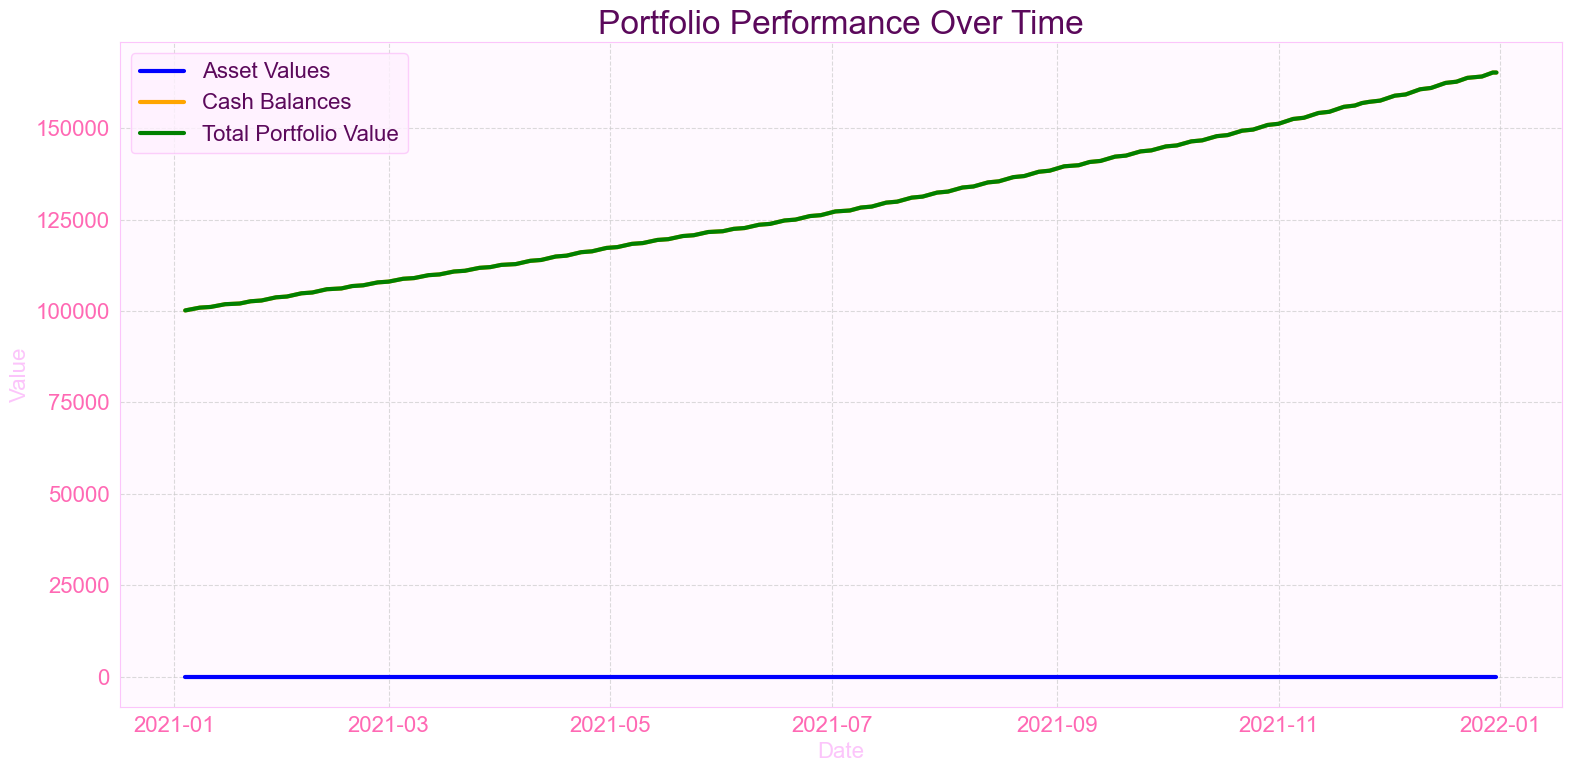

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap

# Debug: Print lengths of all lists

data = trader.collect_information()
dates = data['dates']
asset_values = data['asset_values']
cash_balances = data['cash_balances']
total_values = data['total_values']
transactions = data['transactions']
transactions_df = pd.DataFrame(transactions)


transactions_df = transactions_df.loc[transactions_df['num_shares'] != 0]  
print(f"Length of dates: {len(dates)}")
print(f"Length of asset_values: {len(asset_values)}")
print(f"Length of cash_balances: {len(cash_balances)}")
print(f"Length of total_values: {len(total_values)}")

# Ensure all lists are of the same length by trimming or padding
min_length = min(len(dates), len(asset_values), len(cash_balances), len(total_values))
dates = dates[:min_length]


# Convert dates to pandas datetime
dates = pd.to_datetime(dates)

# Create DataFrames
portfolio_df = pd.DataFrame({
    'Date': dates,
    'Asset Values': asset_values,
    'Cash Balances': cash_balances,
    'Total Portfolio Value': total_values
})

# Load transactions data
transactions_df['date'] = pd.to_datetime(transactions_df['date'])

# Set the style
sns.set_style("whitegrid")
# Color settings
pink_colors = [
    '#FFC0CB', '#FFB6C1', '#D8BFD8', '#DDA0DD', '#EE82EE', 
    '#DA70D6', '#FF69B4', '#FF1493', '#DB7093', '#C71585'
]
cmap = ListedColormap(pink_colors)

soft_pink = '#FFF1FF'
vivid_pink = '#FCC5FB'
deep_pink = '#FF69B4'
purple = '#FCF1FF'
light_purple = '#FFF9FF'
plum = '#5B095B'

plt.rcParams.update({
    'font.size': 16,
    'axes.facecolor': light_purple,
    'axes.edgecolor': vivid_pink,
    'axes.labelcolor': vivid_pink,
    'xtick.color': deep_pink,
    'ytick.color': deep_pink,
    'text.color': plum,
    'legend.facecolor': soft_pink,
    'legend.edgecolor': vivid_pink,
    'figure.facecolor': 'white'
})

# Plot asset values, cash balances, and total portfolio value over time
plt.figure(figsize=(16, 8))
plt.plot(portfolio_df['Date'], portfolio_df['Asset Values'], label='Asset Values', color='blue', linewidth=3)
plt.plot(portfolio_df['Date'], portfolio_df['Cash Balances'], label='Cash Balances', color='orange', linewidth=3)
plt.plot(portfolio_df['Date'], portfolio_df['Total Portfolio Value'], label='Total Portfolio Value', color='green', linewidth=3)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Portfolio Performance Over Time', fontsize=24)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


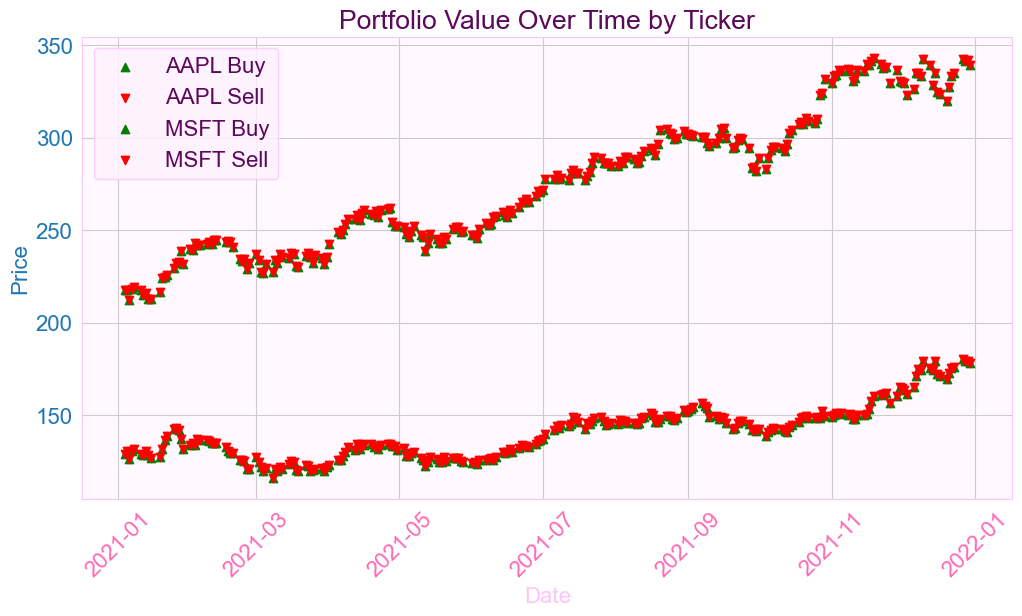

In [33]:
# Sort by ticker and date, and plot the transactions by ticker
transactions_df.sort_values(by=['ticker', 'date'], inplace=True)

# Plotting the transaction trends over time
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')

for ticker in transactions_df['ticker'].unique():
    ticker_data = transactions_df[transactions_df['ticker'] == ticker]
    # ax1.plot(ticker_data['date'], ticker_data['price'], label=ticker)

    # Plot buy points
    buy_data = ticker_data[ticker_data['type'] == 'buy']
    ax1.scatter(buy_data['date'], buy_data['price'], color='green', marker='^', label=f'{ticker} Buy')

    # Plot sell points
    sell_data = ticker_data[ticker_data['type'] == 'sell']
    ax1.scatter(sell_data['date'], sell_data['price'], color='red', marker='v', label=f'{ticker} Sell')

ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('Price', color=color)
ax1.set_title('Portfolio Value Over Time by Ticker')
plt.xticks(rotation=45)
plt.legend()
plt.show()
